## Load packages and functions

In [65]:
import os
os.chdir("./concert/src")
os.getcwd()

'/n/data1/hms/dbmi/zitnik/lab/users/xianglin226/concert/src'

In [66]:
import os
import sys
import os
from time import time
import torch
from concert_batch_2D_stroke import CONCERT
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize
import pandas as pd

In [67]:
def str_list_to_unique_index(str_list):
        original_numbers = np.array([sum(ord(char) for char in s) for s in str_list])
        renumbered = {num: idx + 1 for idx, num in enumerate(sorted(set(original_numbers)))}
        new_numbers = [renumbered[num] for num in original_numbers]
        return np.array(new_numbers)

def sample_fixed_spots(spots, center, num_spots):
    """
    Selects a fixed number of closest spots from the given coordinates.

    Parameters:
        spots (numpy array): Nx2 array of (x, y) coordinates.
        center (tuple): (x, y) coordinates of the patch center.
        num_spots (int): The number of spots to sample.

    Returns:
        numpy array: The subset of closest spots.
    """
    distances = np.sqrt((spots[:, 0] - center[0])**2 + (spots[:, 1] - center[1])**2)
    closest_indices = np.argsort(distances)[:num_spots]
    patch_spots = spots[closest_indices]
    return patch_spots, closest_indices

## Read data in h5 format

In [68]:
data_mat = h5py.File("../datasets/Mouse_brain_stroke_all_data.h5", 'r')
count = np.array(data_mat['X']).astype('float32') # count matrix
loc = np.array(data_mat['Pos']).T.astype('float32') # count matrix
batch_ = np.array(data_mat['Batch']).astype('str') # tissue information
batch = np.array([1 if i.startswith("PT") else 0 for i in batch_])
batch = np.eye(2)[batch]
y = np.array(data_mat['Celltype_coarse']).astype('str')
barcodes = np.array(data_mat['Barcode']).astype('str')
perturbation_ = np.array(data_mat['Celltype_coarse']).astype('str') # perturbation information
perturbation = np.array([1 if i == "ICA" else 0 for i in perturbation_])
genes = np.array(data_mat['Gene']).astype('str')
data_mat.close()

## Setup cell attribute matrix

In [69]:
pert_dic = {perturbation_[i]: perturbation[i] for i in range(len(perturbation_))}
cell_atts = perturbation[:, None]
sample_indices = torch.tensor(np.arange(count.shape[0]), dtype=torch.int)

## Scale and normalize data 

In [70]:
loc_range = 20
n_batch = batch.shape[1]
loc_scaled = np.zeros(loc.shape, dtype=np.float64)
for i in range(n_batch):
    scaler = MinMaxScaler()
    b_loc = loc[batch[:,i]==1., :]
    b_loc = scaler.fit_transform(b_loc) * loc_range
    loc_scaled[batch[:,i]==1., :] = b_loc
loc = loc_scaled
loc = np.concatenate((loc, batch), axis=1)

adata = sc.AnnData(count, dtype="float32")
adata = normalize(adata,size_factors=True,normalize_input=True,logtrans_input=True)

/n/data1/hms/dbmi/zitnik/lab/users/xianglin226/concert/src/concert_env/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/n/data1/hms/dbmi/zitnik/lab/users/xianglin226/concert/src/preprocess.py:53: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata)
/n/data1/hms/dbmi/zitnik/lab/users/xianglin226/concert/src/concert_env/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:591: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


## Setup inducing points

In [71]:
eps = 1e-5
inducing_point_steps = 6
initial_inducing_points_0_ = np.mgrid[0:(1+eps):(1./inducing_point_steps), 0:(1+eps):(1./inducing_point_steps)].reshape(2, -1).T * loc_range
initial_inducing_points_0 = np.tile(initial_inducing_points_0_, (n_batch, 1))
initial_inducing_points_1 = []
for i in range(n_batch):
    initial_inducing_points_1_ = np.zeros((initial_inducing_points_0_.shape[0], n_batch))
    initial_inducing_points_1_[:, i] = 1
    initial_inducing_points_1.append(initial_inducing_points_1_)
initial_inducing_points_1 = np.concatenate(initial_inducing_points_1, axis=0)
initial_inducing_points = np.concatenate((initial_inducing_points_0, initial_inducing_points_1), axis=1)
print(initial_inducing_points.shape)

(98, 4)


## Model setup

In [72]:
GP_dim = 2
Normal_dim = 8
encoder_layers = [128, 64]
decoder_layers = [64, 128]
noise = 0.1
dropoutE = 0.1
dropoutD = 0
shared_dispersion = False
fix_inducing_points = True
fixed_gp_params = False
kernel_scale = 20.
allow_batch_kernel_scale = True
KL_loss = 0.025
dynamicVAE = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
init_beta = 10
min_beta = 5
max_beta = 25
model = CONCERT(cell_atts=cell_atts, num_genes=adata.n_vars, input_dim=256, GP_dim=GP_dim, Normal_dim=Normal_dim, n_batch=n_batch, encoder_layers=encoder_layers, decoder_layers=decoder_layers,
        noise=noise, encoder_dropout=dropoutE, decoder_dropout=dropoutD, shared_dispersion=shared_dispersion,
        fixed_inducing_points=fix_inducing_points, initial_inducing_points=initial_inducing_points, 
        fixed_gp_params=fixed_gp_params, kernel_scale=kernel_scale, allow_batch_kernel_scale=allow_batch_kernel_scale,
        N_train=adata.n_obs, KL_loss=KL_loss, dynamicVAE=dynamicVAE, init_beta=init_beta, min_beta=min_beta, max_beta=max_beta, 
        dtype=torch.float32, device=device)

print(str(model))

Number of covariates:  1
CONCERT(
  (svgp): SVGP(
    (kernel): BatchedCauchyKernel()
    (sample_kernel): SampleKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ELU(alpha=1.0)
      (7): Dropout(p=0.1, inplace=False)
    )
    (enc_mu): Linear(in_features=64, out_features=10, bias=True)
    (enc_var): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=64, out_fe

## Train model or load weights

In [73]:
model_file = 'model_stroke2d.pt'
lr = 1e-3
weight_decay = 1e-6
batch_size = 256
num_samples = 1
train_size = 0.95
maxiter = 5000
patience = 200
if not os.path.isfile(model_file):
    t0 = time()
    model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors, batch=batch,
            lr=lr, weight_decay=weight_decay, batch_size=batch_size, num_samples=num_samples,
            train_size=train_size, maxiter=maxiter, patience=patience, save_model=True, model_weights=model_file)
    print('Training time: %d seconds.' % int(time() - t0))
else:
    model.load_model(model_file)

In [32]:
n_list = [10,20,40,80,100,200]
pert_batch = "Sham1"
target_cell_perturbation = "ICA"
count_list = []
att_list = []
for i in n_list:
    n = i
    print(f"perturb {n} spots...")
    ind = np.where(batch_==pert_batch)[0]
    ind = ind[np.where(y[ind] == "CTX")[0]]
    pert_ind = np.random.choice(ind, n, replace=False)
    #np.savetxt(args.outdir + f"stroke_pert_ind_random_{n}.txt", pert_ind, fmt="%i")
    
    perturbed_counts, perturbed_atts = model.counterfactualPrediction(X=loc, sample_index=sample_indices, cell_atts=cell_atts, batch_size=batch_size, n_samples=25,
                                                      perturb_cell_id = pert_ind,
                                                      target_cell_perturbation = pert_dic[target_cell_perturbation]
                                                      )

    perturbed_counts = perturbed_counts[batch_== pert_batch, :]
    count_list.append(perturbed_counts)
    att_list.append([i]*perturbed_counts.shape[0])

perturb 10 spots...


/n/data1/hms/dbmi/zitnik/lab/users/xianglin226/concert/src/concert_batch_2D_stroke.py:761: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_sample_indices = torch.tensor(sample_index, dtype=torch.int)


perturb 20 spots...
perturb 40 spots...
perturb 80 spots...
perturb 100 spots...
perturb 200 spots...


## Visualize expression of a ischemic central gene.

In [33]:
data_mat = h5py.File('../datasets/Mouse_brain_stroke_all_data.h5', 'r')
loc = np.array(data_mat['Pos']).T.astype('float32') # location information
loc = loc[:, :2]
loc = np.concatenate([loc[batch_== pert_batch,:]]*len(n_list), axis=0)
att_list = np.concatenate(att_list, axis=0)
count_list = np.concatenate(count_list, axis=0)
marker = 'Gm42418'
count_list_ = count_list[:,np.where(genes==marker)[0][0]]
data_mat.close()

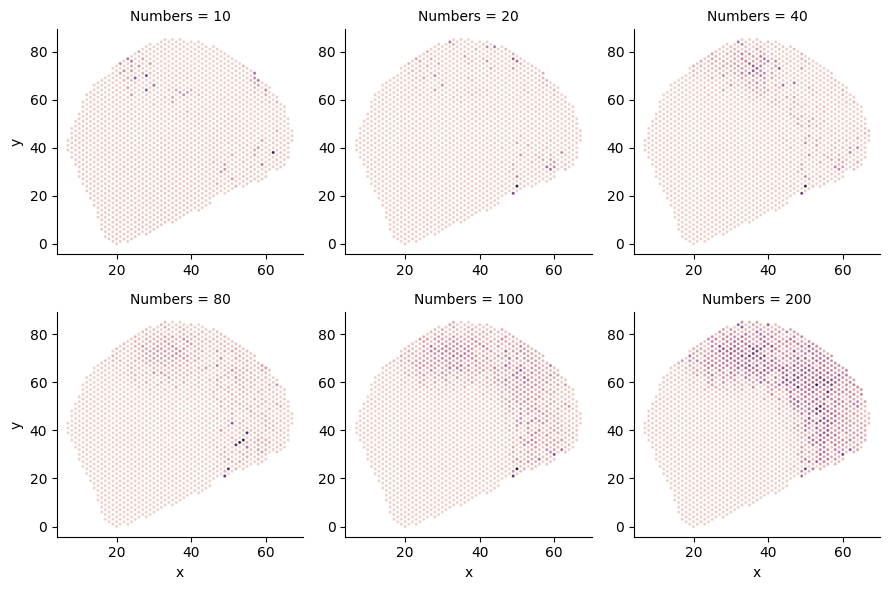

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "x": loc[:,0],
    "y": loc[:,1],
    "Numbers": att_list,
    "Gm42418": count_list_,
})

g = sns.FacetGrid(df, col="Numbers", col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", hue="Gm42418", s=5)
plt.show()

## Do patch sampling

In [77]:
data_mat = h5py.File('../datasets/Mouse_brain_stroke_all_data.h5', 'r')
loc = np.array(data_mat['Pos']).T.astype('float32') # location information
loc = loc[:, :2]
n_list = [10,20,40,80,100,200]
pert_batch = "Sham1"
target_cell_perturbation = "ICA"
pert_ind = np.loadtxt("../pert_cells/pert_cells_stroke_sham1_CIA.txt", dtype=int) - 1
center_ind = pert_ind[100] # randomly choose a center for sampling
ind = np.where(batch_ == pert_batch)[0][0] - 1
pert_ind = pert_ind + ind
loc_batch = loc[batch_ == pert_batch, :]
ind_batch = np.where(batch_ == pert_batch)[0]
center = loc_batch[center_ind]
#scale loc here
loc_scaled = np.zeros(loc.shape, dtype=np.float64)
for i in range(n_batch):
    scaler = MinMaxScaler()
    b_loc = loc[batch[:,i]==1., :]
    b_loc = scaler.fit_transform(b_loc) * loc_range
    loc_scaled[batch[:,i]==1., :] = b_loc
loc = loc_scaled
loc = np.concatenate((loc, batch), axis=1)
##
count_list = []
att_list = []
for i in n_list:
    n = i
    print(f"perturb {n} spots...")
    _,patch_ind = sample_fixed_spots(loc_batch, center, n)
    pert_ind = ind_batch[patch_ind]
    #np.savetxt(args.outdir + f"stroke_pert_ind_patch_{n}.txt", pert_ind, fmt="%i")
    
    perturbed_counts, perturbed_atts = model.counterfactualPrediction(X=loc, sample_index=sample_indices, cell_atts=cell_atts, batch_size=batch_size, n_samples=25,
                                                      perturb_cell_id = pert_ind,
                                                      target_cell_perturbation = pert_dic[target_cell_perturbation]
                                                      )

    perturbed_counts = perturbed_counts[batch_== pert_batch, :]
    count_list.append(perturbed_counts)
    att_list.append([i]*perturbed_counts.shape[0])

perturb 10 spots...


/n/data1/hms/dbmi/zitnik/lab/users/xianglin226/concert/src/concert_batch_2D_stroke.py:761: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_sample_indices = torch.tensor(sample_index, dtype=torch.int)


perturb 20 spots...
perturb 40 spots...
perturb 80 spots...
perturb 100 spots...
perturb 200 spots...


## Visualize expression of a ischemic periphery gene.

In [78]:
data_mat = h5py.File('../datasets/Mouse_brain_stroke_all_data.h5', 'r')
loc = np.array(data_mat['Pos']).T.astype('float32') # location information
loc = loc[:, :2]
loc = np.concatenate([loc[batch_== pert_batch,:]]*len(n_list), axis=0)
att_list = np.concatenate(att_list, axis=0)
count_list = np.concatenate(count_list, axis=0)
marker = 'Lcn2'
count_list_ = count_list[:,np.where(genes==marker)[0][0]]

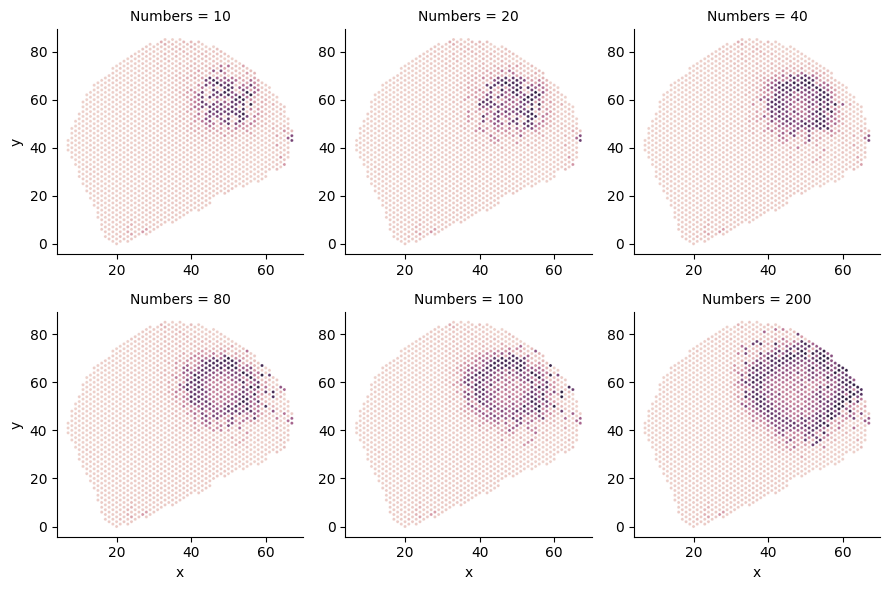

In [79]:
df = pd.DataFrame({
    "x": loc[:,0],
    "y": loc[:,1],
    "Numbers": att_list,
    "Lcn2": count_list_,
})

g = sns.FacetGrid(df, col="Numbers", col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", hue="Lcn2", s=5)
plt.show()